In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
full_data = np.load('full_data.npz')["full_data"]

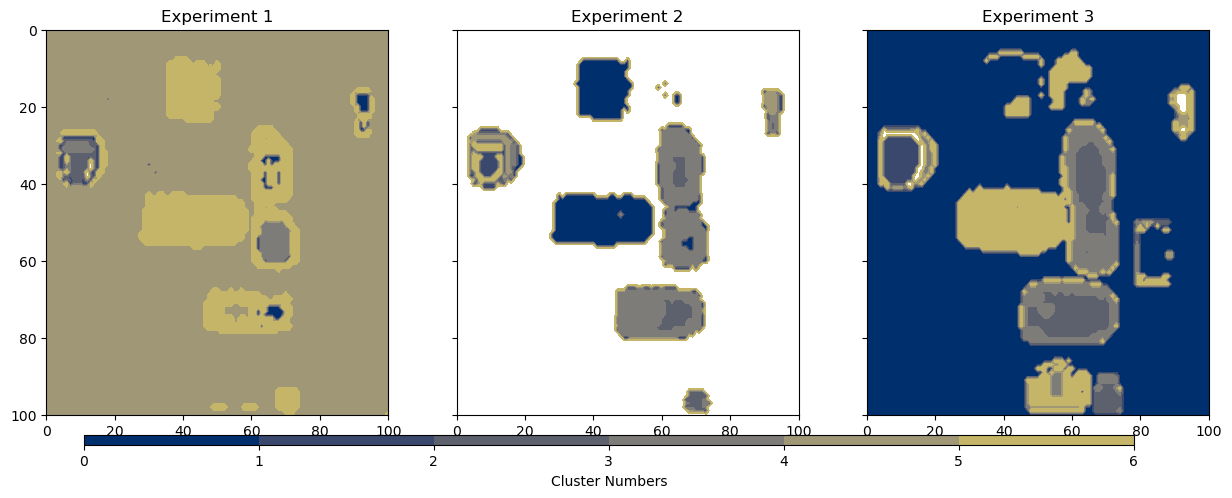

In [4]:
clust_labs = []  
k = 7
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

#clustering on first three experiments for training
for ix in range(3):  
    used_data = np.reshape(full_data[ix], (101 * 101, 4999)) 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.abs(used_data))
    kmeans.fit(scaled_data)
    cluster_labels = kmeans.labels_
    cluster_labels = np.reshape(cluster_labels, (101, 101))  
    clust_labs.append(cluster_labels)


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ix, ax in enumerate(axs.flat):
    pp = ax.contourf(clust_labs[ix] + 1, cmap="cividis", vmin=0, vmax=7, levels=np.arange(7))
    ax.set_ylim(100, 0)
    ax.set_title(f"Experiment {ix + 1}")

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
fig.colorbar(pp, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_xlabel("Cluster Numbers")

plt.show()


In [5]:
#Count signals in each cluster for Experiments 1-3
for experiment_idx, cluster_labels in enumerate(clust_labs): 
    print(f"Experiment {experiment_idx + 1}:")
    
    #Flatten the cluster labels to count occurrences
    flattened_labels = cluster_labels.flatten()
    unique_labels, counts = np.unique(flattened_labels, return_counts=True)
    
    #Print the counts for each cluster
    for label, count in zip(unique_labels, counts):
        print(f"  Cluster {label}: {count} signals")
    print()  


Experiment 1:
  Cluster 0: 110 signals
  Cluster 1: 18 signals
  Cluster 2: 69 signals
  Cluster 3: 101 signals
  Cluster 4: 8816 signals
  Cluster 5: 1079 signals
  Cluster 6: 8 signals

Experiment 2:
  Cluster 0: 753 signals
  Cluster 1: 65 signals
  Cluster 2: 190 signals
  Cluster 3: 607 signals
  Cluster 4: 39 signals
  Cluster 5: 43 signals
  Cluster 6: 8504 signals

Experiment 3:
  Cluster 0: 7911 signals
  Cluster 1: 126 signals
  Cluster 2: 551 signals
  Cluster 3: 542 signals
  Cluster 4: 58 signals
  Cluster 5: 958 signals
  Cluster 6: 55 signals



In [6]:
experiment_labels = {
    0: {0: "Transient", 1: "Transient", 2: "Transient", 3: "Transient", 4: "Non-Transient", 5: "Transient", 6: "Transient"},
    1: {0: "Transient", 1: "Transient", 2: "Transient", 3: "Transient", 4: "Transient", 5: "Transient", 6: "Non-Transient"},
    2: {0: "Non-Transient", 1: "Transient", 2: "Transient", 3: "Transient", 4: "Transient", 5: "Transient", 6: "Transient"}
}


In [7]:
# Feature extraction function
import numpy as np

def extract_features(signal):
    peak_amplitude = np.max(signal)  
    std_dev = np.std(signal)  
    slope = (signal[-1] - signal[0]) / len(signal) 
    return [peak_amplitude, std_dev, slope]

train_features = []
train_labels = []

for ix in range(3):  
    for x in range(101):
        for y in range(101):
            signal = full_data[ix, x, y, :] 
            cluster = clust_labs[ix][x, y] 
            label = experiment_labels[ix][cluster]  
            train_features.append(extract_features(signal))  
            train_labels.append(label)  

In [8]:
from sklearn.model_selection import train_test_split

label_mapping = {"Transient": 1, "Non-Transient": 0}
y_train = np.array([label_mapping[label] for label in train_labels])
X_train = np.array(train_features)



In [9]:
scaler = StandardScaler()  # Scale features for KNN
X_train = scaler.fit_transform(X_train)


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print("KNN model trained successfully.")

KNN model trained successfully.


C:\Users\sawoo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


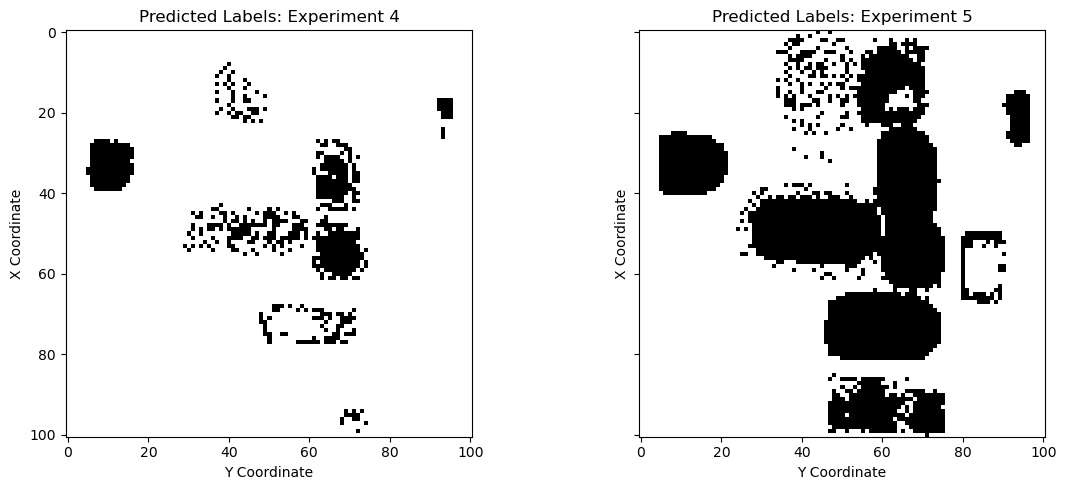

Experiment 4:
  Transient (1): 680 signals
  Non-Transient (0): 9521 signals

Experiment 5:
  Transient (1): 2673 signals
  Non-Transient (0): 7528 signals



In [11]:
#Test on Experiments 4-5
test_features = []
spatial_indices = []

for ix in range(3, 5):  
    for x in range(101):
        for y in range(101):
            signal = full_data[ix, x, y, :]
            test_features.append(extract_features(signal))
            spatial_indices.append((ix - 3, x, y))

X_test = np.array(test_features)
X_test = scaler.transform(X_test) 
y_test_pred = knn.predict(X_test)

#Map predictions back to spatial grid
predicted_maps = np.zeros((2, 101, 101))
for (exp_idx, x, y), label in zip(spatial_indices, y_test_pred):
    predicted_maps[exp_idx, x, y] = label

# Visualize predictions for Experiments 4-5
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for idx, ax in enumerate(axs.flat):
    ax.imshow(predicted_maps[idx], cmap="gray_r", origin="upper")
    ax.set_title(f"Predicted Labels: Experiment {idx + 4}")
    ax.set_xlabel("Y Coordinate")
    ax.set_ylabel("X Coordinate")

plt.tight_layout()
plt.show()

for i, predicted_map in enumerate(predicted_maps):
    transient_count = np.sum(predicted_map == 1)
    non_transient_count = np.sum(predicted_map == 0)
    print(f"Experiment {i + 4}:")
    print(f"  Transient (1): {transient_count} signals")
    print(f"  Non-Transient (0): {non_transient_count} signals\n")

# Experiment 4: Comparing Mode Thresholding to Machine Learning Clustering

Similarity Between Thresholding and ML Predictions: 85.12%
Thresholding Classification Counts (Experiment 5):
  Transient (1): 2198
  Non-Transient (0): 8003

ML Model Prediction Counts (Experiment 5):
  Transient (1): 680
  Non-Transient (0): 9521


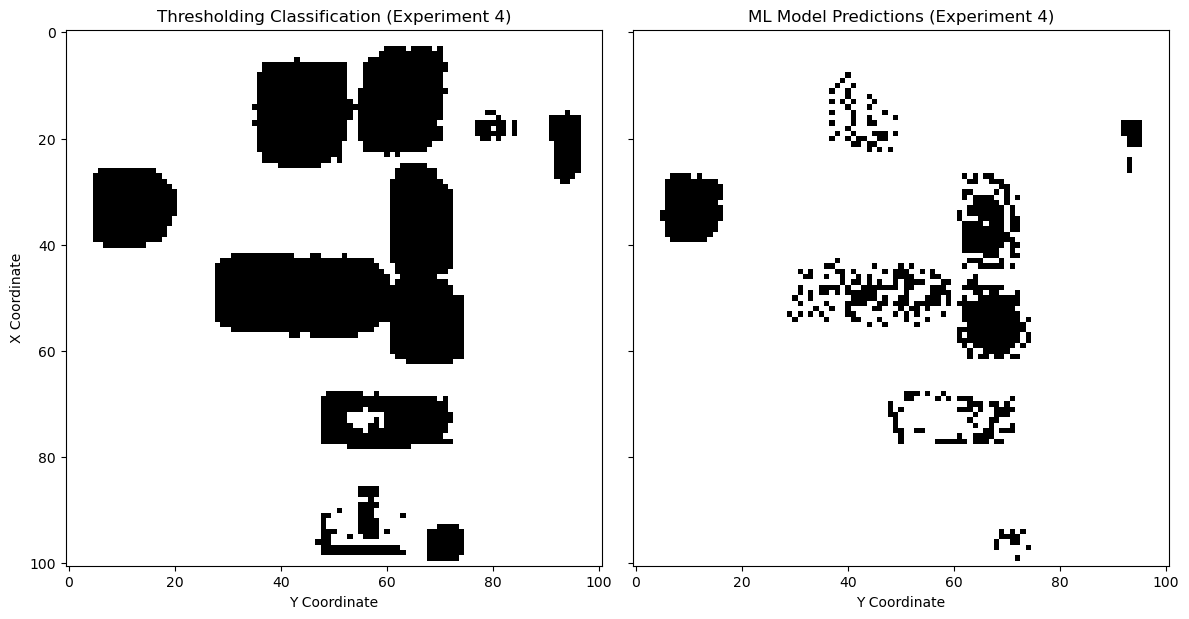

In [12]:
import numpy as np
import matplotlib.pyplot as plt

#Step 1: Thresholding results for Experiment 4
run_four = full_data[3]  
mode = 50
std_dev = np.std(run_four)
k = 1.1

upper_threshold = mode + k * std_dev
lower_threshold = mode - k * std_dev

# Thresholding classification
thresholding_matrix = np.zeros((run_four.shape[0], run_four.shape[1]), dtype=int)
for x in range(run_four.shape[0]):
    for y in range(run_four.shape[1]):
        signal = run_four[x, y]  
        is_transient = np.any(signal > upper_threshold) or np.any(signal < lower_threshold)
        thresholding_matrix[x, y] = 1 if is_transient else 0

#Step 2: ML predictions for Experiment 4
ml_predictions = predicted_maps[0] 

#Step 3: Calculate Similarity
similarity = np.sum(thresholding_matrix == ml_predictions) / thresholding_matrix.size
print(f"Similarity Between Thresholding and ML Predictions: {similarity * 100:.2f}%")

#Step 4: Count and Print Number of Transients and Non-Transients
threshold_transients = np.sum(thresholding_matrix == 1)
threshold_non_transients = np.sum(thresholding_matrix == 0)

ml_transients = np.sum(ml_predictions == 1)
ml_non_transients = np.sum(ml_predictions == 0)

print("Thresholding Classification Counts (Experiment 4):")
print(f"  Transient (1): {threshold_transients}")
print(f"  Non-Transient (0): {threshold_non_transients}")

print("\nML Model Prediction Counts (Experiment 4):")
print(f"  Transient (1): {ml_transients}")
print(f"  Non-Transient (0): {ml_non_transients}")

#Step 5: Visualize Side-by-Side Heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

#Thresholding results
axs[0].imshow(thresholding_matrix, cmap="gray_r", origin="upper")
axs[0].set_title("Thresholding Classification (Experiment 4)")
axs[0].set_xlabel("Y Coordinate")
axs[0].set_ylabel("X Coordinate")

# ML predictions
axs[1].imshow(ml_predictions, cmap="gray_r", origin="upper")
axs[1].set_title("ML Model Predictions (Experiment 4)")
axs[1].set_xlabel("Y Coordinate")

plt.tight_layout()
plt.show()


# Experiment 5: Comparing Mode Thresholding to Machine Learning Clustering

Similarity Between Thresholding and ML Predictions: 73.51%
Thresholding Classification Counts (Experiment 5):
  Transient (1): 5375
  Non-Transient (0): 4826

ML Model Prediction Counts (Experiment 5):
  Transient (1): 2673
  Non-Transient (0): 7528


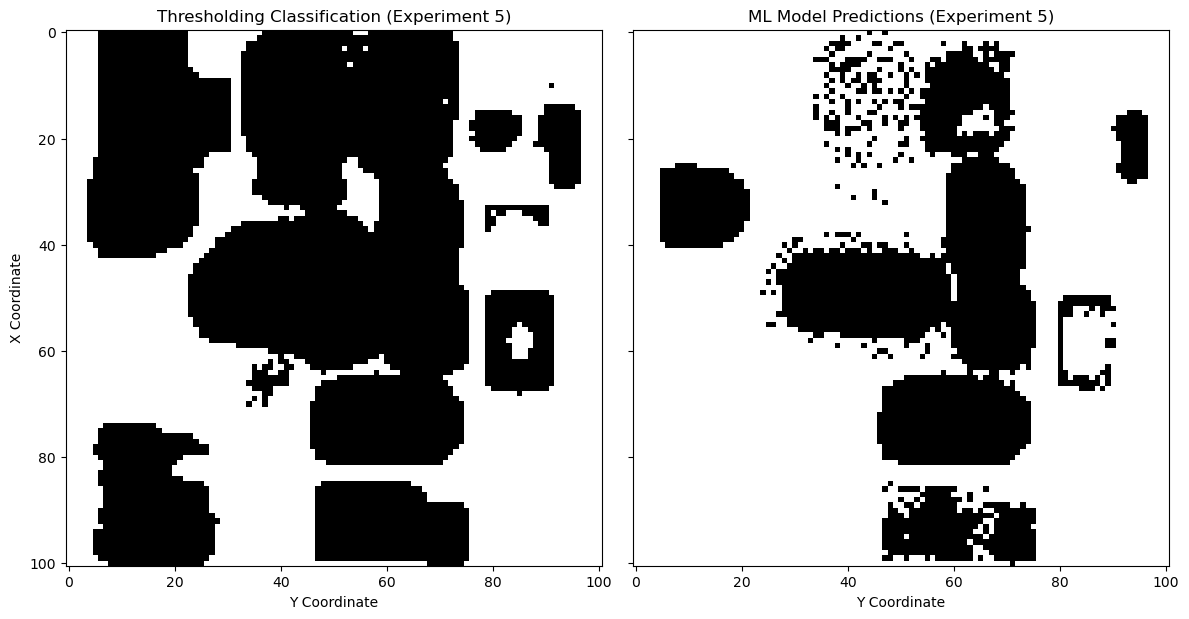

In [36]:
import numpy as np
import matplotlib.pyplot as plt

#Step 1: Thresholding results for Experiment 5
run_five = full_data[4]  # Experiment 5
mode = 50
std_dev = np.std(run_five)
k = 0.4  

upper_threshold = mode + k * std_dev
lower_threshold = mode - k * std_dev

#Thresholding classification
thresholding_matrix = np.zeros((run_five.shape[0], run_five.shape[1]), dtype=int)
for x in range(run_five.shape[0]):
    for y in range(run_five.shape[1]):
        signal = run_five[x, y]  
        is_transient = np.any(signal > upper_threshold) or np.any(signal < lower_threshold)
        thresholding_matrix[x, y] = 1 if is_transient else 0

#Step 2: ML predictions for Experiment 5
ml_predictions = predicted_maps[1]  

#Step 3: Calculate Similarity
similarity = np.sum(thresholding_matrix == ml_predictions) / thresholding_matrix.size
print(f"Similarity Between Thresholding and ML Predictions: {similarity * 100:.2f}%")

#Step 4: Count and Print Number of Transients and Non-Transients
threshold_transients = np.sum(thresholding_matrix == 1)
threshold_non_transients = np.sum(thresholding_matrix == 0)

ml_transients = np.sum(ml_predictions == 1)
ml_non_transients = np.sum(ml_predictions == 0)

print("Thresholding Classification Counts (Experiment 5):")
print(f"  Transient (1): {threshold_transients}")
print(f"  Non-Transient (0): {threshold_non_transients}")

print("\nML Model Prediction Counts (Experiment 5):")
print(f"  Transient (1): {ml_transients}")
print(f"  Non-Transient (0): {ml_non_transients}")

#Step 5: Visualize Side-by-Side Heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

#Thresholding results
axs[0].imshow(thresholding_matrix, cmap="gray_r", origin="upper")
axs[0].set_title("Thresholding Classification (Experiment 5)")
axs[0].set_xlabel("Y Coordinate")
axs[0].set_ylabel("X Coordinate")

axs[1].imshow(ml_predictions, cmap="gray_r", origin="upper")
axs[1].set_title("ML Model Predictions (Experiment 5)")
axs[1].set_xlabel("Y Coordinate")

plt.tight_layout()
plt.show()
